# RGCN Substructure Masking Explanation

## Setup

In [30]:


import os, glob, io, traceback, logging
from typing import List, Dict, Optional
import torch
import numpy as np
import pandas as pd
from PIL import Image
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from torch_geometric.data import Batch

# Project imports
from model import BaseGNN
from build_data import (
    construct_mol_graph_from_smiles,
    return_murcko_leaf_structure,
)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
log = logging.getLogger('rgcn-xai-notebook')

def find_checkpoints(n: int = 5, folder: str = 'model_checkpoints') -> List[str]:
    paths = sorted(glob.glob(os.path.join(folder, '*.ckpt')))
    if len(paths) < n:
        log.warning(f'Found {len(paths)} checkpoints in {folder}; proceeding with available.')
    return paths[:n]

class _MinimalConfig:
    def __init__(self, in_dim: int, num_edge_types: int = 65, classification: bool = True):
        self.num_node_features = in_dim
        self.num_edge_types = num_edge_types
        self.classification = classification

def _ensure_batch(graph):
    # Ensure a .batch attribute so BaseGNN readout works
    if not hasattr(graph, 'batch') or graph.batch is None:
        import torch as _torch
        graph.batch = _torch.zeros(graph.x.size(0), dtype=_torch.long, device=graph.x.device)
    return graph

def get_proper_murcko_scaffolds(smiles: str) -> Dict[int, List[int]]:
    """
    Get proper Murcko scaffolds using RDKit's official implementation with validation.
    
    Returns:
        Dict mapping scaffold_id to list of atom indices
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return {}
        
        # Check if molecule has rings
        if mol.GetRingInfo().NumRings() == 0:
            log.debug(f"Molecule has no rings, skipping Murcko analysis: {smiles}")
            return {}
        
        # Get the official Murcko scaffold
        try:
            scaffold_mol = MurckoScaffold.GetScaffoldForMol(mol)
            if scaffold_mol is None:
                return {}
            
            # Ensure the scaffold has a reasonable size (at least 3 atoms)
            if scaffold_mol.GetNumAtoms() < 3:
                log.debug(f"Murcko scaffold too small ({scaffold_mol.GetNumAtoms()} atoms): {smiles}")
                return {}
                
        except Exception as e:
            log.debug(f"Failed to get Murcko scaffold: {e}")
            return {}
        
        # Map scaffold atoms back to original molecule
        scaffold_smiles = Chem.MolToSmiles(scaffold_mol)
        
        # Find scaffold atoms in original molecule using substructure matching
        matches = mol.GetSubstructMatches(scaffold_mol)
        
        scaffolds = {}
        for i, match in enumerate(matches):
            # Ensure scaffold has minimum size and contains rings
            if len(match) >= 3:
                # Verify that the matched atoms actually contain ring atoms
                ring_atoms_in_match = sum(1 for atom_idx in match if mol.GetAtomWithIdx(atom_idx).IsInRing())
                if ring_atoms_in_match >= 3:  # At least 3 ring atoms
                    scaffolds[i] = list(match)
                else:
                    log.debug(f"Scaffold match has insufficient ring atoms ({ring_atoms_in_match}): {match}")
            else:
                log.debug(f"Scaffold match too small ({len(match)} atoms): {match}")
        
        # If no matches found, try the fallback method but with better validation
        if not scaffolds:
            log.debug(f"No proper Murcko scaffolds found using substructure matching, trying fallback for: {smiles}")
            return get_validated_ring_systems(mol)
        
        log.debug(f"Found {len(scaffolds)} proper Murcko scaffolds for: {smiles}")
        return scaffolds
        
    except Exception as e:
        log.error(f"Error in get_proper_murcko_scaffolds for {smiles}: {e}")
        return {}

def get_validated_ring_systems(mol) -> Dict[int, List[int]]:
    """
    Fallback method to get ring systems with proper validation.
    Only returns systems that represent true molecular frameworks.
    """
    try:
        # Get all ring systems
        ring_info = mol.GetRingInfo()
        ring_systems = []
        
        # Group rings that share atoms (fused rings)
        processed_rings = set()
        
        for i, ring in enumerate(ring_info.AtomRings()):
            if i in processed_rings:
                continue
                
            ring_set = set(ring)
            # Find all rings that share atoms with this ring
            fused_system = ring_set.copy()
            
            for j, other_ring in enumerate(ring_info.AtomRings()):
                if j <= i or j in processed_rings:
                    continue
                    
                other_set = set(other_ring)
                # If rings share atoms, they're part of the same system
                if ring_set & other_set:
                    fused_system.update(other_set)
                    processed_rings.add(j)
            
            # Only keep ring systems with minimum size
            if len(fused_system) >= 6:  # At least 6 atoms (benzene ring)
                ring_systems.append(list(fused_system))
            
            processed_rings.add(i)
        
        # Convert to scaffold dictionary
        scaffolds = {}
        for i, system in enumerate(ring_systems):
            # Additional validation: ensure it's actually a connected system
            if validate_ring_system(mol, system):
                scaffolds[i] = system
        
        return scaffolds
        
    except Exception as e:
        log.error(f"Error in get_validated_ring_systems: {e}")
        return {}

def validate_ring_system(mol, atom_indices: List[int]) -> bool:
    """
    Validate that a set of atoms forms a proper ring system.
    
    Returns True if:
    1. System contains at least one complete ring
    2. System is connected
    3. System has reasonable size
    """
    try:
        if len(atom_indices) < 3:
            return False
        
        # Check if atoms form a connected subgraph
        atom_set = set(atom_indices)
        bonds_in_system = 0
        
        for i in atom_indices:
            atom = mol.GetAtomWithIdx(i)
            for neighbor in atom.GetNeighbors():
                if neighbor.GetIdx() in atom_set:
                    bonds_in_system += 1
        
        # Each bond is counted twice, so divide by 2
        bonds_in_system //= 2
        
        # A connected system should have at least (n-1) bonds, 
        # ring systems should have at least n bonds
        min_bonds = len(atom_indices)
        
        return bonds_in_system >= min_bonds
        
    except Exception as e:
        log.error(f"Error validating ring system: {e}")
        return False

def get_proper_murcko_scaffolds(smiles: str) -> Dict[int, List[int]]:
    """
    Get proper Murcko scaffolds using RDKit's official implementation with validation.
    
    Returns:
        Dict mapping scaffold_id to list of atom indices
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return {}
        
        # Check if molecule has rings
        if mol.GetRingInfo().NumRings() == 0:
            log.debug(f"Molecule has no rings, skipping Murcko analysis: {smiles}")
            return {}
        
        # Get the official Murcko scaffold
        try:
            scaffold_mol = MurckoScaffold.GetScaffoldForMol(mol)
            if scaffold_mol is None:
                return {}
            
            # Ensure the scaffold has a reasonable size (at least 3 atoms)
            if scaffold_mol.GetNumAtoms() < 3:
                log.debug(f"Murcko scaffold too small ({scaffold_mol.GetNumAtoms()} atoms): {smiles}")
                return {}
                
        except Exception as e:
            log.debug(f"Failed to get Murcko scaffold: {e}")
            return {}
        
        # Map scaffold atoms back to original molecule
        scaffold_smiles = Chem.MolToSmiles(scaffold_mol)
        
        # Find scaffold atoms in original molecule using substructure matching
        matches = mol.GetSubstructMatches(scaffold_mol)
        
        scaffolds = {}
        for i, match in enumerate(matches):
            # Ensure scaffold has minimum size and contains rings
            if len(match) >= 3:
                # Verify that the matched atoms actually contain ring atoms
                ring_atoms_in_match = sum(1 for atom_idx in match if mol.GetAtomWithIdx(atom_idx).IsInRing())
                if ring_atoms_in_match >= 3:  # At least 3 ring atoms
                    scaffolds[i] = list(match)
                else:
                    log.debug(f"Scaffold match has insufficient ring atoms ({ring_atoms_in_match}): {match}")
            else:
                log.debug(f"Scaffold match too small ({len(match)} atoms): {match}")
        
        # If no matches found, try the fallback method but with better validation
        if not scaffolds:
            log.debug(f"No proper Murcko scaffolds found using substructure matching, trying fallback for: {smiles}")
            return get_validated_ring_systems(mol)
        
        log.debug(f"Found {len(scaffolds)} proper Murcko scaffolds for: {smiles}")
        return scaffolds
        
    except Exception as e:
        log.error(f"Error in get_proper_murcko_scaffolds for {smiles}: {e}")
        return {}

def get_validated_ring_systems(mol) -> Dict[int, List[int]]:
    """
    Fallback method to get ring systems with proper validation.
    Only returns systems that represent true molecular frameworks.
    """
    try:
        # Get all ring systems
        ring_info = mol.GetRingInfo()
        ring_systems = []
        
        # Group rings that share atoms (fused rings)
        processed_rings = set()
        
        for i, ring in enumerate(ring_info.AtomRings()):
            if i in processed_rings:
                continue
                
            ring_set = set(ring)
            # Find all rings that share atoms with this ring
            fused_system = ring_set.copy()
            
            for j, other_ring in enumerate(ring_info.AtomRings()):
                if j <= i or j in processed_rings:
                    continue
                    
                other_set = set(other_ring)
                # If rings share atoms, they're part of the same system
                if ring_set & other_set:
                    fused_system.update(other_set)
                    processed_rings.add(j)
            
            # Only keep ring systems with minimum size
            if len(fused_system) >= 6:  # At least 6 atoms (benzene ring)
                ring_systems.append(list(fused_system))
            
            processed_rings.add(i)
        
        # Convert to scaffold dictionary
        scaffolds = {}
        for i, system in enumerate(ring_systems):
            # Additional validation: ensure it's actually a connected system
            if validate_ring_system(mol, system):
                scaffolds[i] = system
        
        return scaffolds
        
    except Exception as e:
        log.error(f"Error in get_validated_ring_systems: {e}")
        return {}

def validate_ring_system(mol, atom_indices: List[int]) -> bool:
    """
    Validate that a set of atoms forms a proper ring system.
    
    Returns True if:
    1. System contains at least one complete ring
    2. System is connected
    3. System has reasonable size
    """
    try:
        if len(atom_indices) < 3:
            return False
        
        # Check if atoms form a connected subgraph
        atom_set = set(atom_indices)
        bonds_in_system = 0
        
        for i in atom_indices:
            atom = mol.GetAtomWithIdx(i)
            for neighbor in atom.GetNeighbors():
                if neighbor.GetIdx() in atom_set:
                    bonds_in_system += 1
        
        # Each bond is counted twice, so divide by 2
        bonds_in_system //= 2
        
        # A connected system should have at least (n-1) bonds, 
        # ring systems should have at least n bonds
        min_bonds = len(atom_indices)
        
        return bonds_in_system >= min_bonds
        
    except Exception as e:
        log.error(f"Error validating ring system: {e}")
        return False

class ClassificationEnsemble:
    def __init__(self, checkpoint_paths: List[str], weights: Optional[List[float]] = None, threshold: float = 0.5, device: Optional[str] = None):
        self.device = torch.device(device if device else ('cuda' if torch.cuda.is_available() else 'cpu'))
        self.threshold = threshold
        self.checkpoint_paths = checkpoint_paths
        self.models: List[BaseGNN] = []
        self.model_feature_dims: List[int] = []

        for path in checkpoint_paths:
            try:
                ckpt = torch.load(path, map_location=self.device)
                if 'state_dict' not in ckpt or 'hyperparameters' not in ckpt:
                    log.error(f'Invalid checkpoint (missing keys): {path}')
                    continue

                # Try to infer input feature dimension from first GNN layer weights, fallback to 40
                in_dim = 40
                first_keys = [k for k in ckpt['state_dict'].keys() if 'rgcn_gnn_layers.0' in k and 'weight' in k]
                if first_keys:
                    w = ckpt['state_dict'][first_keys[0]]
                    if hasattr(w, 'shape') and len(w.shape) > 1:
                        in_dim = w.shape[1]

                cfg = _MinimalConfig(in_dim)
                hp = ckpt['hyperparameters']
                rgcn_hidden_feats = hp.get('rgcn_hidden_feats', [256, 256])
                if isinstance(rgcn_hidden_feats, str):
                    rgcn_hidden_feats = [int(x) for x in rgcn_hidden_feats.replace('[','').replace(']','').replace('(','').replace(')','').replace(' ','').split('-' if '-' in rgcn_hidden_feats else ',') if x]
                ffn_hidden_feats = hp.get('ffn_hidden_feats', 64)
                if isinstance(ffn_hidden_feats, list):
                    ffn_hidden_feats = int(ffn_hidden_feats[0])
                else:
                    ffn_hidden_feats = int(ffn_hidden_feats)

                model = BaseGNN(
                    config=cfg,
                    rgcn_hidden_feats=rgcn_hidden_feats,
                    ffn_hidden_feats=ffn_hidden_feats,
                    ffn_dropout=float(hp.get('ffn_dropout', 0.2)),
                    rgcn_dropout=float(hp.get('rgcn_dropout', 0.1)),
                    classification=True,
                )
                model.load_state_dict(ckpt['state_dict'])
                model.eval().to(self.device)

                self.models.append(model)
                self.model_feature_dims.append(in_dim)
                log.info(f'Loaded {os.path.basename(path)} with input_dim={in_dim}')
            except Exception as e:
                log.error(f'Failed to load {path}: {e}\n{traceback.format_exc()}')

        if not self.models:
            raise RuntimeError('No valid models loaded.')
        if weights is None:
            weights = [1.0] * len(self.models)
        if len(weights) != len(self.models):
            log.warning('Weights length != models; normalizing available weights.')
            weights = (weights + [1.0] * len(self.models))[:len(self.models)]
        s = sum(weights)
        self.weights = [w / s for w in weights]

        # Color scheme per attribution category: positive (blue), negative (red), neutral (grey)
        self.colors = {
            'positive': (0.0, 0.0, 1.0, 0.5),   # Blue
            'negative': (1.0, 0.0, 0.0, 0.5),   # Red
            'neutral':  (0.5, 0.5, 0.5, 0.5),   # Grey
            'masking':  (0.29, 0.0, 0.51, 0.4), # Indigo (fallback)
        }

    def _prepare_graph(self, smiles: str, feature_dim: int, smask: Optional[List[int]] = None):
        g = construct_mol_graph_from_smiles(smiles, smask=(smask or []))
        if g is None or not hasattr(g, 'x'):
            raise ValueError('Graph construction failed or missing node features.')
        if g.x.shape[1] != feature_dim:
            x = g.x
            if x.shape[1] > feature_dim:
                x = x[:, :feature_dim].clone()
            else:
                new_x = torch.zeros((x.shape[0], feature_dim), device=x.device, dtype=x.dtype)
                new_x[:, :x.shape[1]] = x
                x = new_x
            g.x = x
        g = _ensure_batch(g).to(self.device)
        return g

    def predict(self, smiles: str) -> float:
        preds = []
        for model, fdim, w in zip(self.models, self.model_feature_dims, self.weights):
            try:
                g = self._prepare_graph(smiles, fdim, smask=[])
                batch = Batch.from_data_list([g])
                with torch.no_grad():
                    out, _ = model(batch)
                    p = torch.sigmoid(out).item()
                preds.append((p, w))
            except Exception as e:
                log.error(f'Prediction error on a model: {e}')
        if not preds:
            raise RuntimeError('No valid predictions.')
        total_w = sum(w for _, w in preds)
        return sum(p * (w / total_w) for p, w in preds)

    def analyze_attribution(self, smiles: str) -> List[Dict]:
        # Murcko-only attribution
        base_pred = self.predict(smiles)
        subs = return_murcko_leaf_structure(smiles).get('substructure', {})

        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError('Invalid SMILES.')

        results = []
        for key, atoms in subs.items():
            if not atoms:
                continue
            masked_preds = []
            for model, fdim, w in zip(self.models, self.model_feature_dims, self.weights):
                try:
                    g = self._prepare_graph(smiles, fdim, smask=atoms)
                    batch = Batch.from_data_list([g])
                    with torch.no_grad():
                        out, _ = model(batch)
                        p = torch.sigmoid(out).item()
                    masked_preds.append((p, w))
                except Exception as e:
                    log.debug(f'Masked prediction error: {e}')
            if not masked_preds:
                continue
            total_w = sum(w for _, w in masked_preds)
            masked = sum(p * (w / total_w) for p, w in masked_preds)
            attr = base_pred - masked
            impact = 'Minimal impact on activity'
            color = self.colors['neutral']
            if attr > 0.1:
                impact, color = 'Increases probability of activity', self.colors['positive']
            elif attr < -0.1:
                impact, color = 'Decreases probability of activity', self.colors['negative']

            sub_smiles = Chem.MolFragmentToSmiles(mol, atomsToUse=atoms, kekuleSmiles=True)
            results.append({
                'substructure': sub_smiles,
                'atoms': atoms,
                'attribution': float(attr),
                'impact': impact,
                'original_prediction': float(base_pred),
                'masked_prediction': float(masked),
                'original_class': int(base_pred >= self.threshold),
                'masked_class': int(masked >= self.threshold),
                'class_change': (base_pred >= self.threshold) != (masked >= self.threshold),
                'color': color,
            })

        results.sort(key=lambda x: abs(x['attribution']), reverse=True)
        return results

    def generate_visualization(self, mol=None, smiles=None, highlight_atoms=None, highlight_color=None, show_indices=False) -> Image.Image:
        if mol is None and smiles:
            mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError('mol or smiles required')
        if mol.GetNumConformers() == 0:
            rdDepictor.Compute2DCoords(mol)
        
        # Use larger canvas and better settings for publication quality
        drawer = rdMolDraw2D.MolDraw2DCairo(1200, 900)
        opts = drawer.drawOptions()
        opts.addAtomIndices = show_indices  # Now defaults to False
        opts.atomLabelFontSize = 22
        opts.bondLineWidth = 2.5
        opts.highlightBondWidthMultiplier = 6
        opts.padding = 0.15
        opts.useBWAtomPalette = False  # Use colored atoms
        opts.clearBackground = True
        opts.backgroundColour = (1, 1, 1, 1)  # White background
        
        if highlight_atoms and highlight_color:
            hb = []
            for i in range(len(highlight_atoms)):
                for j in range(i+1, len(highlight_atoms)):
                    b = mol.GetBondBetweenAtoms(highlight_atoms[i], highlight_atoms[j])
                    if b: hb.append(b.GetIdx())
            atom_colors = {i: highlight_color for i in highlight_atoms}
            bond_colors = {i: highlight_color for i in hb}
            drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms, highlightBonds=hb, highlightAtomColors=atom_colors, highlightBondColors=bond_colors)
        else:
            drawer.DrawMolecule(mol)
        drawer.FinishDrawing()
        return Image.open(io.BytesIO(drawer.GetDrawingText()))

    def visualize_attribution(self, smiles: str, results: List[Dict]) -> Dict[str, Image.Image]:
        mol = Chem.MolFromSmiles(smiles)
        imgs = {'original': self.generate_visualization(mol=mol, show_indices=False)}
        # Combined view: color Murcko substructures by attribution category
        if results:
            atom_colors = {}
            bond_colors = {}
            for r in results:
                atoms = r['atoms']
                col = r['color']
                for a in atoms:
                    atom_colors[a] = col
                # Color bonds connecting atoms within this substructure
                for i in range(len(atoms)):
                    for j in range(i+1, len(atoms)):
                        b = mol.GetBondBetweenAtoms(atoms[i], atoms[j])
                        if b:
                            bond_colors[b.GetIdx()] = col
            # Render combined with per-atom colors
            from rdkit.Chem.Draw import rdMolDraw2D as _rd
            drawer = _rd.MolDraw2DCairo(1200, 900)
            opts = drawer.drawOptions()
            opts.addAtomIndices = False
            opts.atomLabelFontSize = 22
            opts.bondLineWidth = 2.5
            opts.highlightBondWidthMultiplier = 6
            opts.padding = 0.15
            opts.useBWAtomPalette = False
            opts.clearBackground = True
            opts.backgroundColour = (1, 1, 1, 1)
            drawer.DrawMolecule(mol, highlightAtoms=list(atom_colors.keys()), highlightBonds=list(bond_colors.keys()), 
                              highlightAtomColors=atom_colors, highlightBondColors=bond_colors)
            drawer.FinishDrawing()
            imgs['all_substructures'] = Image.open(io.BytesIO(drawer.GetDrawingText()))
        for i, r in enumerate(results[:10], 1):
            imgs[f'substructure_{i}'] = self.generate_visualization(mol=mol, highlight_atoms=r['atoms'], highlight_color=r['color'], show_indices=False)
        return imgs

# Confirmation that all classes and functions are loaded successfully
print("✅ All utilities, ensemble, and explainability functions loaded successfully!")
print("   Ready to initialize ensemble and run molecular analysis.")

✅ All utilities, ensemble, and explainability functions loaded successfully!
   Ready to initialize ensemble and run molecular analysis.


# User entry — set SMILES and run (Murcko-only)

2025-09-08 22:15:38 - WARNING - model - Number of classes not provided, defaulting to binary classification
2025-09-08 22:15:38,921 - WARNING - Number of classes not provided, defaulting to binary classification
2025-09-08 22:15:38,921 - WARNING - Number of classes not provided, defaulting to binary classification
2025-09-08 22:15:38 - INFO - model - Initialized for classification with 2 classes
2025-09-08 22:15:38,965 - INFO - Initialized for classification with 2 classes
2025-09-08 22:15:38,971 - INFO - Loaded S_aureus_classification_cv1_fold1_best.ckpt with input_dim=40
2025-09-08 22:15:38 - WARNING - model - Number of classes not provided, defaulting to binary classification
2025-09-08 22:15:38 - INFO - model - Initialized for classification with 2 classes
2025-09-08 22:15:38,965 - INFO - Initialized for classification with 2 classes
2025-09-08 22:15:38,971 - INFO - Loaded S_aureus_classification_cv1_fold1_best.ckpt with input_dim=40
2025-09-08 22:15:38 - WARNING - model - Number o

✅ Ensemble ready! Loaded 5 models on cpu

SMILES: n1(C2CC2)cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc12
Ensemble probability: 0.9763  -> Active (threshold: 0.5)


,Substructure,Attribution,Impact,Masked Prob,Class Change
0,O=CO,0.883875,Increases probability of activity,0.092378,True
1,O=C1C=CNC2=CC=C(F)C=C12,0.861673,Increases probability of activity,0.114581,True
2,C1CC1,0.068278,Minimal impact on activity,0.907975,False
3,C1CNCCN1,0.020572,Minimal impact on activity,0.955681,False


Results saved to murcko_explainability_results.csv
Original molecule:
Original molecule:


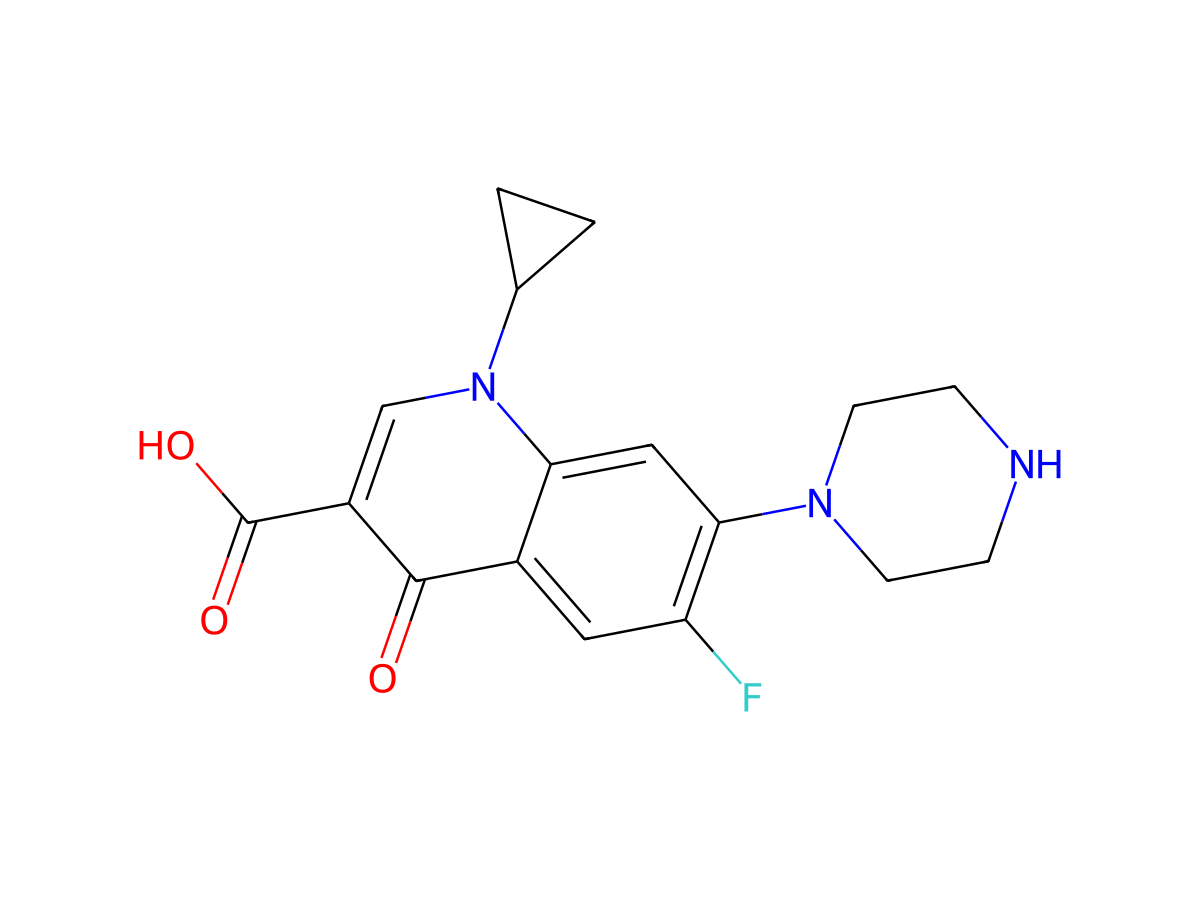

All highlighted substructures:


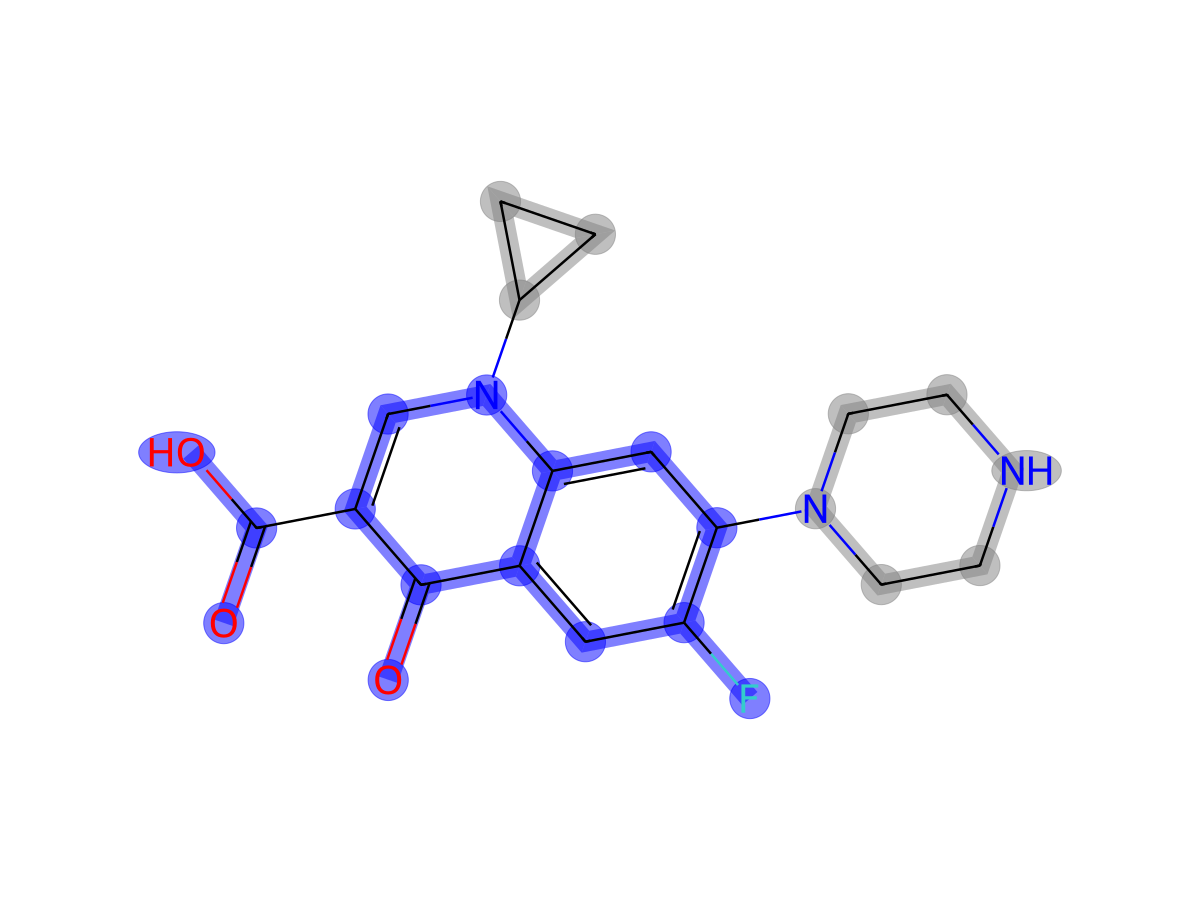

Substructure 1


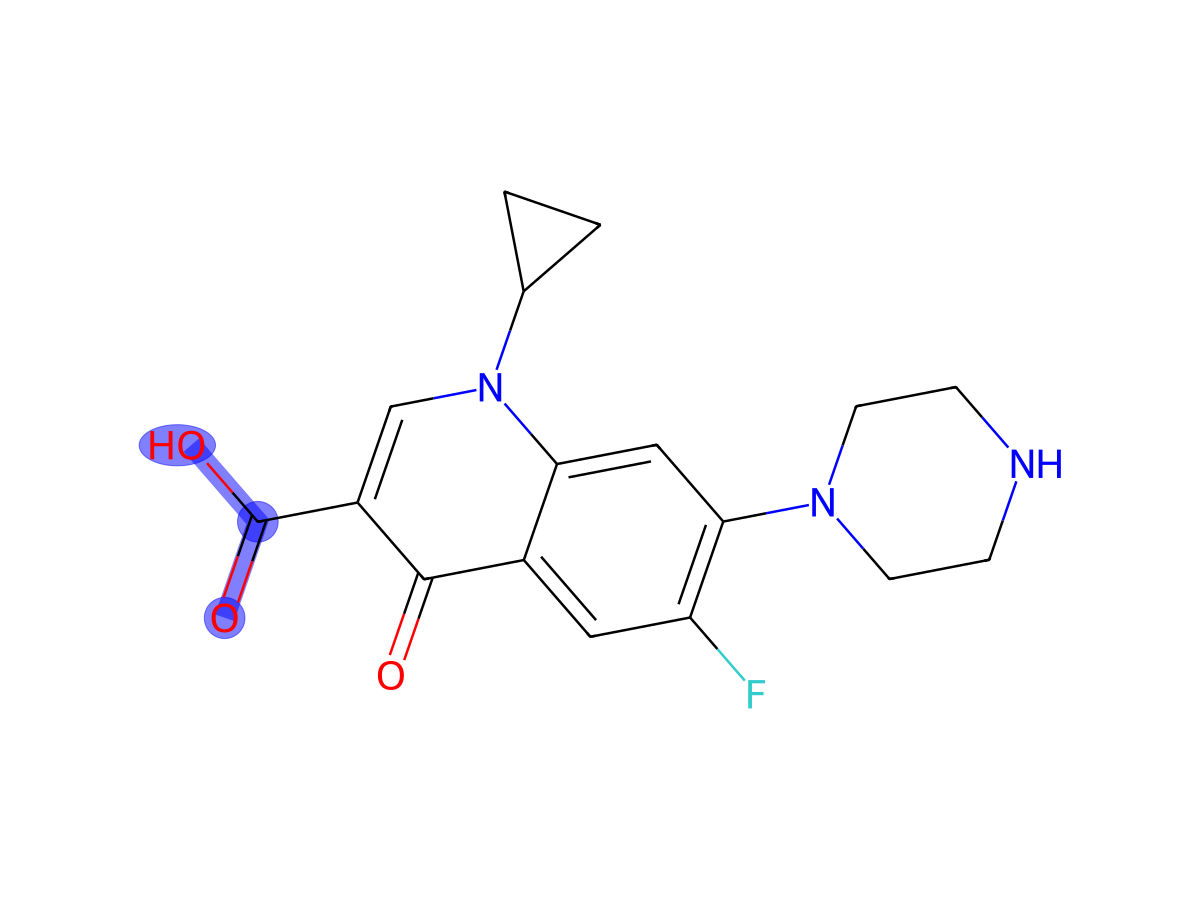

Substructure 2


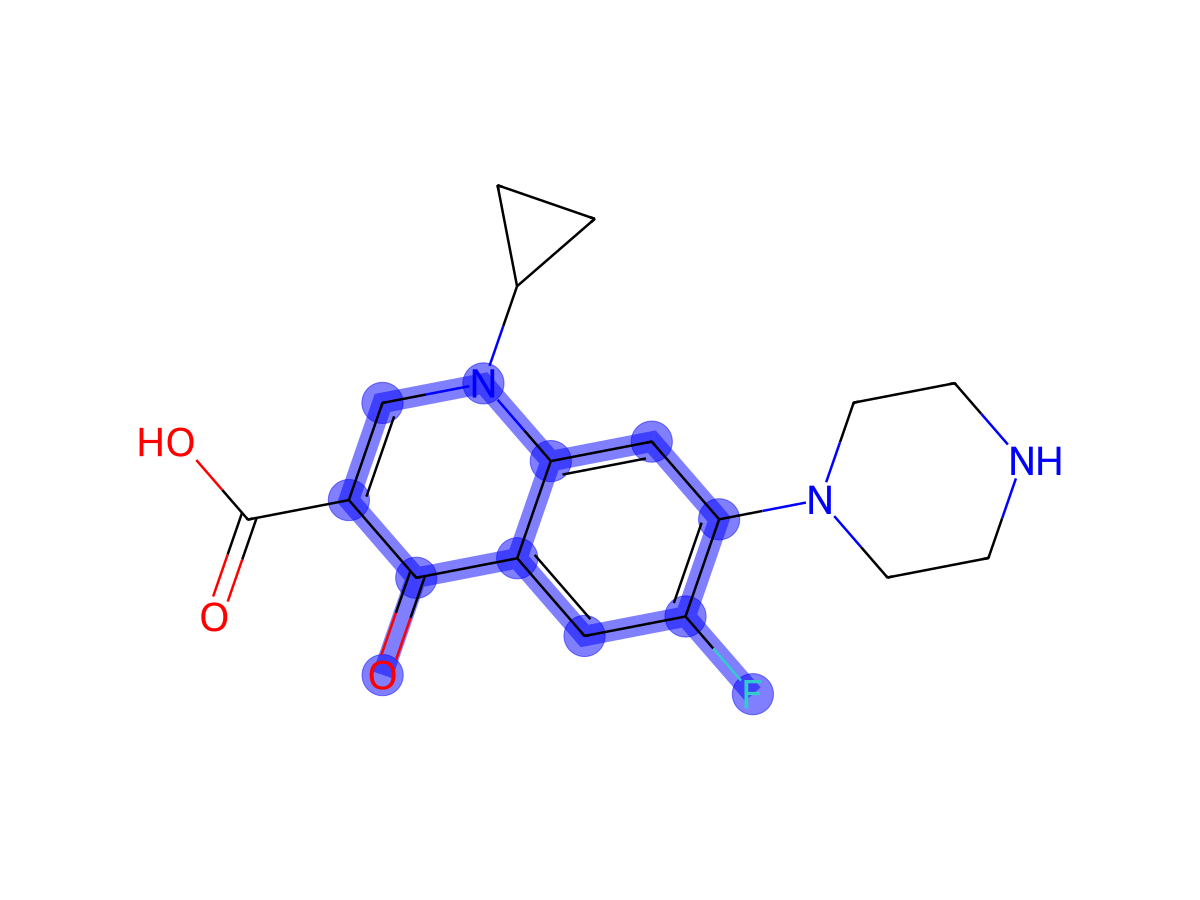

Substructure 3


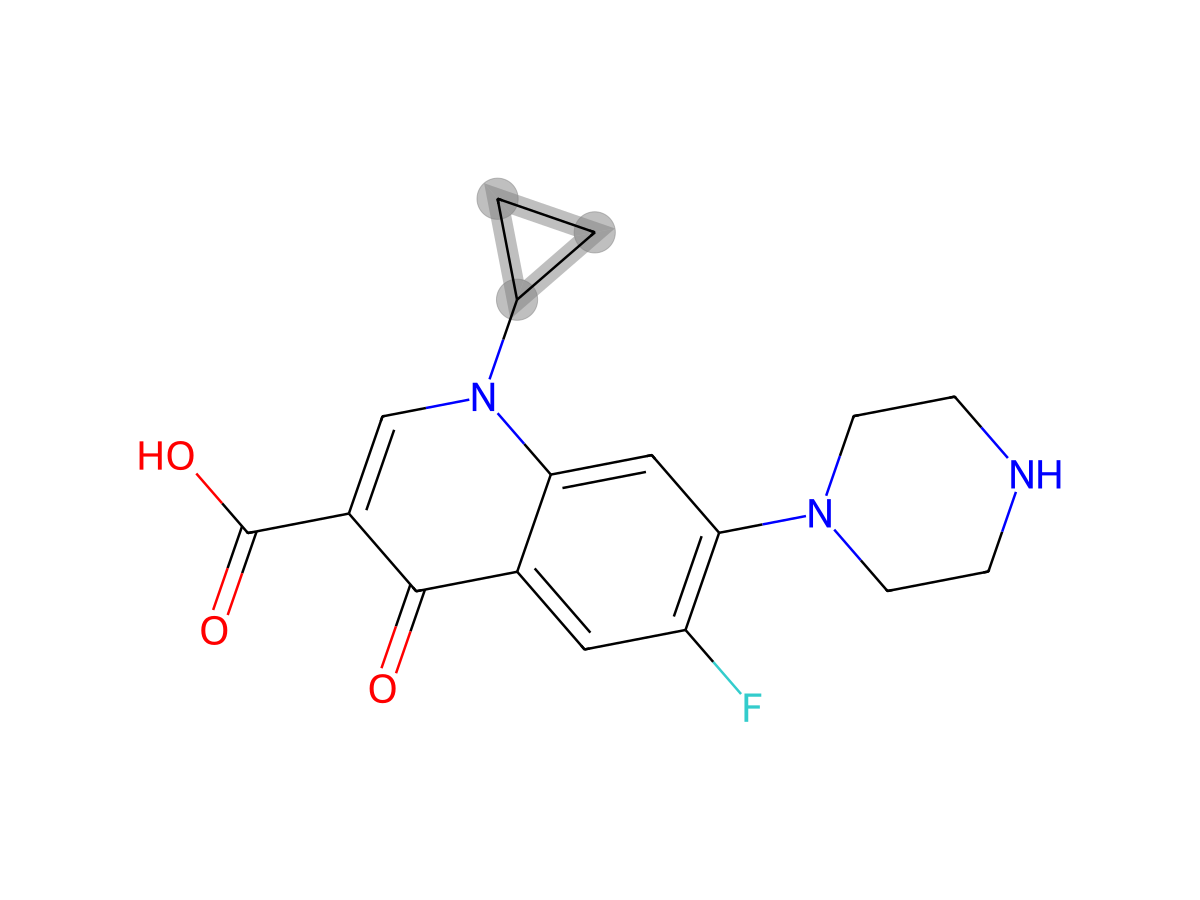

Substructure 4


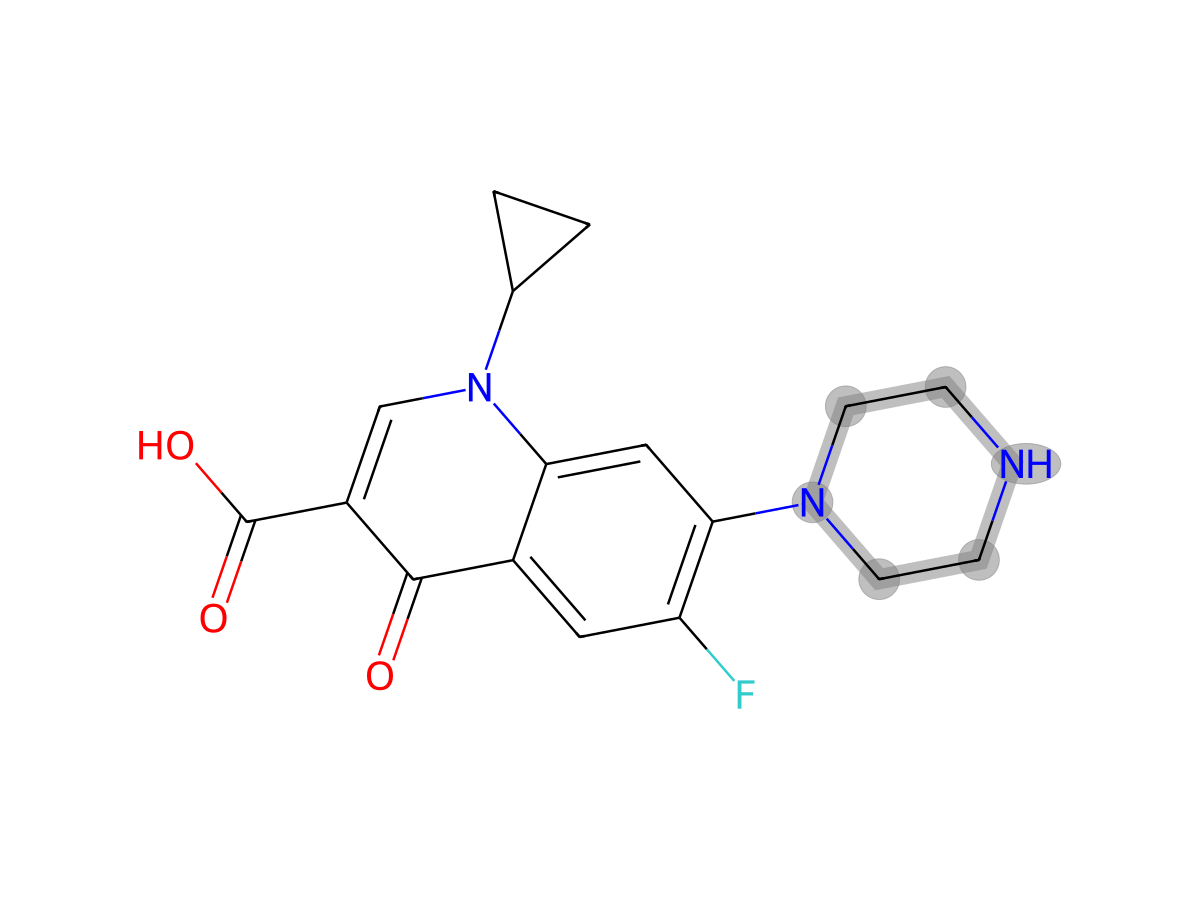

In [33]:

from IPython.display import display

# Load up to 5 checkpoints in model_checkpoints/
ckpts = find_checkpoints(5, 'model_checkpoints')
ensemble = ClassificationEnsemble(ckpts, threshold=0.5)
print(f"✅ Ensemble ready! Loaded {len(ensemble.models)} models on {ensemble.device}")

# Edit/comment/uncomment these SMILES as needed
smiles = 'n1(C2CC2)cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc12'  # ciprofloxacin - active -
#smiles ='FC1=C(C=C(N(C=C(C(OCC2=CC=C([N+]([O-])=O)C=C2)=O)C3=O)C4CC4)C3=C1)N5CCNCC5'  # prodrug 2 - 
#smiles = 'FC1=C(C=C(N(C=C(C(O)=O)C2=O)C3CC3)C2=C1)N4CCN(C(OCC5=CC=C(N=[N+]=[N-])C=C5)=O)CC4' #prodrug 4 -0.9089  Site-Specific Antimicrobial Activity of a Dual-Responsive Ciprofloxacin Prodrug




print('\n' + '='*80)
print(f'SMILES: {smiles}')
p = ensemble.predict(smiles)
label = 'Active' if p >= ensemble.threshold else 'Inactive'
print(f'Ensemble probability: {p:.4f}  -> {label} (threshold: {ensemble.threshold})')

# Explainability (Murcko-only)
results = ensemble.analyze_attribution(smiles)
df = pd.DataFrame([{
    'Substructure': r['substructure'],
    'Attribution': r['attribution'],
    'Impact': r['impact'],
    'Masked Prob': r['masked_prediction'],
    'Class Change': r['class_change'],
} for r in results[:10]])
if not df.empty:
    display(df)
    # Save results to CSV file
    df.to_csv('murcko_explainability_results.csv', index=False)
    print(f"Results saved to murcko_explainability_results.csv")
    

# Visualize
viz = ensemble.visualize_attribution(smiles, results)
if 'original' in viz:
    print('Original molecule:')
    display(viz['original'])
if 'all_substructures' in viz:
    print('All highlighted substructures:')
    display(viz['all_substructures'])
for k in sorted([k for k in viz.keys() if k.startswith('substructure_')], key=lambda x: int(x.split('_')[1])):
    print(k.replace('_', ' ').title())
    display(viz[k])